# Weekly analysis

In [176]:
import warnings
warnings.filterwarnings('ignore')
import os
import zipfile
import pandas as pd
import numpy as np
import tqdm
from tensorly.decomposition import non_negative_parafac

# Plot
import contextily as cx
from pyproj import Proj, transform
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.4, style='darkgrid')

In [183]:
OUTDIR = '../out/decomposition/'
os.makedirs(OUTDIR, exist_ok=True)

In [2]:
def cleaning(df, user_type=None, add_user_age=True):

    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ', '')

    df = df.dropna(subset=['birthyear'])

    if user_type is not None:
        assert user_type in ['Subscriber', 'Customer']
        df = df.query('usertype==@user_type')

    df = df.query('startstationlongitude!=0')
    df = df.query('startstationlatitude!=0')
    df = df.query('endstationlongitude!=0')
    df = df.query('endstationlatitude!=0')

    df.loc[:, 'starttime'] = pd.to_datetime(df.starttime)
    df.loc[:, 'stoptime'] = pd.to_datetime(df.stoptime)
    df.loc[:, 'year'] = df.starttime.dt.year
    df.loc[:, 'hour'] = df.starttime.dt.hour
    df.loc[:, 'weekday'] = df.starttime.dt.weekday.astype(str).str.cat(
        df.starttime.dt.day_name().str[:3], sep='-')
    df.loc[:, 'weekday-hour'] = df.hour.astype(str).str.cat(
        df.starttime.dt.day_name().str[:3], sep='-')

    if add_user_age:
        df.loc[:, 'user_age'] = df.year - df.birthyear
        df = df.query('user_age>=0')
        df = df.query('user_age<=80')

    return df


In [3]:
def load_data(date=None, date_from=None, date_to=None, clean=True):
    """
        date: (str) e.g., '201701'
    """

    if date is not None:
        zip_file = zipfile.ZipFile(
            f'../rawdata/{date}-citibike-tripdata.csv.zip')
        data = pd.read_csv(zip_file.open(zip_file.namelist()[0]))
        # data = pd.read_csv(f'../rawdata/{date}-citibike-tripdata.csv.zip', compression='zip')
        if clean:
            return cleaning(data)
        else:
            return data

    else:
        if date_from is not None and date_to is not None:
            return pd.concat([load_data(date=date.strftime("%Y%m"))
                              for date in pd.date_range(start=date_from, end=date_to, freq='M')])
        else:
            return None


In [4]:
def define_non_temporal_modes(df, facets, freq_rate=0.9, skip_mode=None):
    
    if skip_mode is None:
        skip_mode = [False] * len(facets)

    # Extracting the top [freq_rate] % attritbutes for each mode
    freq_rates = df[facets].nunique().values * freq_rate
    freq_shape = freq_rates.astype(int)
    freq_entities = [df.groupby(a).size().sort_values().iloc[-r:].index if not s else [] for a, r, s in zip(facets, freq_shape, skip_mode)]

    # Filtering out the infrequent attributes
    valid_events = df
    for i, (mode, skip) in enumerate(zip(facets, skip_mode)):
        if not skip:
            valid_events = valid_events[valid_events[mode].isin(freq_entities[i])]

    print('Filtered out {} samples'.format(df.shape[0] - valid_events.shape[0]))

    # Getting the attributes to keep track
    multi_index = valid_events.groupby(facets).size().rename('size').to_frame()
    multi_index = multi_index.unstack(fill_value=0).stack()

    shape = valid_events[facets].nunique().values.astype(int)

    return multi_index, shape

In [5]:
df = load_data('201702')
df.head()

,tripduration,starttime,stoptime,startstationid,startstationname,startstationlatitude,startstationlongitude,endstationid,endstationname,endstationlatitude,endstationlongitude,bikeid,usertype,birthyear,gender,year,hour,weekday,weekday-hour,user_age
0,1087,2017-02-01 00:00:13,2017-02-01 00:18:20,345,W 13 St & 6 Ave,40.736494,-73.997044,305,E 58 St & 3 Ave,40.760958,-73.967245,17432,Subscriber,1966.0,1,2017,0,2-Wed,0-Wed,51.0
2,212,2017-02-01 00:00:34,2017-02-01 00:04:06,336,Sullivan St & Washington Sq,40.730477,-73.999061,439,E 4 St & 2 Ave,40.726281,-73.989780,16826,Subscriber,1984.0,1,2017,0,2-Wed,0-Wed,33.0
3,1140,2017-02-01 00:00:44,2017-02-01 00:19:44,484,W 44 St & 5 Ave,40.755003,-73.980144,3295,Central Park W & W 96 St,40.791270,-73.964839,27052,Subscriber,1980.0,1,2017,0,2-Wed,0-Wed,37.0
4,320,2017-02-01 00:00:42,2017-02-01 00:06:02,490,8 Ave & W 33 St,40.751551,-73.993934,3431,E 35 St & 3 Ave,40.746524,-73.977885,25238,Subscriber,1987.0,1,2017,0,2-Wed,0-Wed,30.0
5,277,2017-02-01 00:00:56,2017-02-01 00:05:34,285,Broadway & E 14 St,40.734546,-73.990741,251,Mott St & Prince St,40.723180,-73.994800,20617,Subscriber,1975.0,1,2017,0,2-Wed,0-Wed,42.0


## 3rd-order tensor: (time, station, user_age)

Filtered out 7999 samples


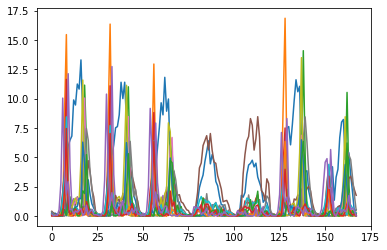

In [33]:
skip_mode = [False, False]
facets = ['startstationid', 'user_age']
multi_index, shape = define_non_temporal_modes(df, facets, skip_mode=skip_mode)

rank = 15
time_range = 168
sub_tensor = np.zeros((time_range, *shape))

for t, (d, g) in enumerate(df.set_index('starttime').groupby(pd.Grouper(freq='H'))):
    # t: time point
    # d: datetime information
    # g: trip data in an hour

    events = multi_index.join(g.groupby(facets).size().rename('data'), how='left')
    tensor = events.data.fillna(0.).values.reshape((-1, *shape))
    # print(tensor.shape)
    sub_tensor[t % time_range] = tensor

    if t % time_range == time_range - 1:
        # Perform tensnor decomposition
        weights, factors = non_negative_parafac(sub_tensor, rank)
        plt.plot(factors[0])
        plt.show()
        break

In [179]:
def plot_time_component(factors, mode, component_id=0, date_range=None, ax=None, dt=24):

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    ax.plot(factors[mode][:, component_id])

    ax.set_xticks(np.arange(0, len(factors[mode]), dt))
    ax.set_xticklabels(date_range[0::dt], rotation=90)
    ax.set_xlabel("Time")
    ax.set_ylabel("Component strength")
    ax.set_title("Time component")
    ax.set_xlim(0, len(ax.get_xticks()) * dt)
    # ax.grid()

    return

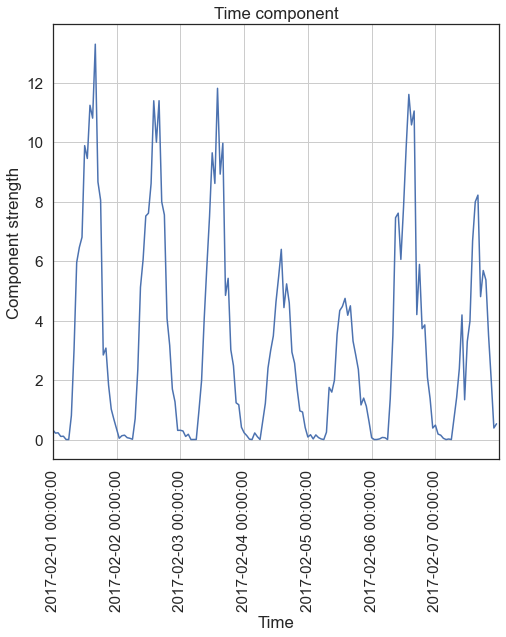

In [174]:
date_range = pd.date_range(end=d, periods=time_range, freq='H')
plot_time_component(factors, mode=0, component_id=0, date_range=date_range)

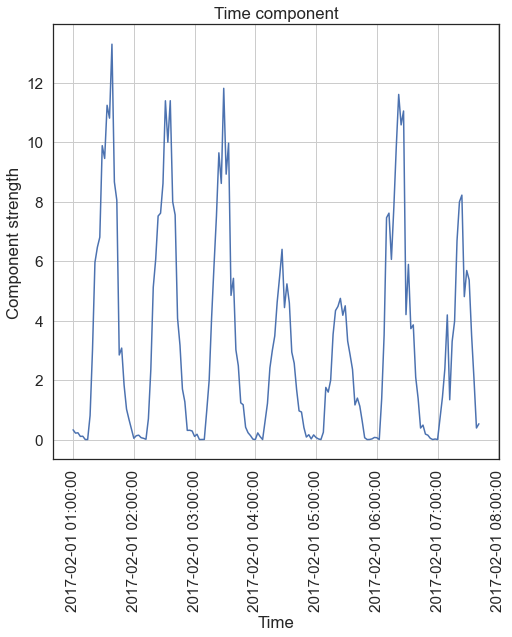

In [94]:
component_id = 0
date_range = pd.date_range(end=d, periods=time_range, freq='H')

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(factors[0][:, component_id])
ax.set_xticklabels(date_range, rotation=90)
ax.set_xlabel("Time")
ax.set_ylabel("Component strength")
ax.set_title("Time component")
ax.grid()

In [34]:
def my_transform(df):
    lon = df.iloc[1]
    lat = df.iloc[0]
    # Available for CitiBike dataset
    return transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), lat, lon)

In [199]:
def plot_geo_component(factors, multi_index, mode, component_id=0, geo_data=None, ax=None):
    # TODO: meshgrid and gaussian filtering -> fill up the map

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 12))

    # Getting one component
    facet_name = multi_index.index.names[mode - 1]
    geo_factor = factors[mode]
    geo_indice = multi_index.reset_index()[facet_name].unique()
    geo_component = pd.DataFrame(geo_factor[:, component_id],
                                 columns=['component'],
                                 index=geo_indice)
    
    geo_component = geo_component.join(geo_data, how='left')
    
    sns.scatterplot(data=geo_component,
        x='trans_lon', y='trans_lat',
        marker='s',
        alpha=0.75,
        size='component',
        # palette='viridis',
        # palette=sns.color_palette("vlag", as_cmap=True),
        # palette=sns.color_palette("icefire", as_cmap=True),
        palette=sns.diverging_palette(250, 300, l=65, center="dark", as_cmap=True),
        edgecolor='none', hue='component',
        ax=ax)

    ax.legend(fancybox=False)
    ax.axis('off')
    ax.margins(0)

    cx.add_basemap(ax)
    # fig.tight_layout()
    # fig.savefig('sample-map.pdf', bbox_inches='tight', pad_inches=0)
    
    return ax

(<Figure size 720x864 with 1 Axes>,
 <AxesSubplot:xlabel='trans_lon', ylabel='trans_lat'>)

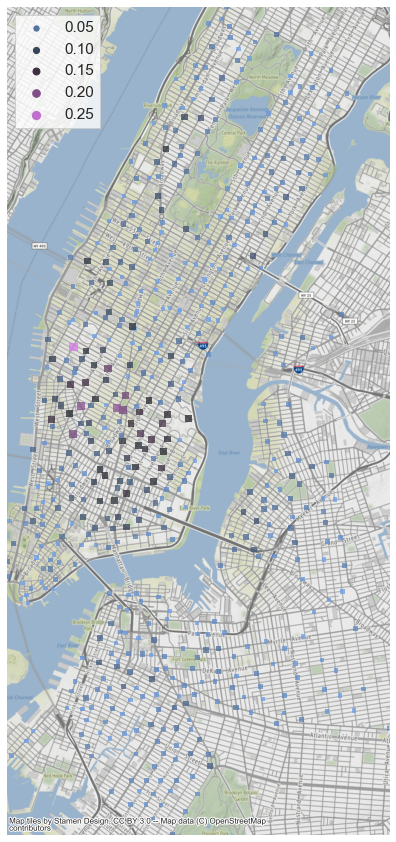

In [126]:
plot_geo_component(factors, multi_index, mode=1, component_id=5)

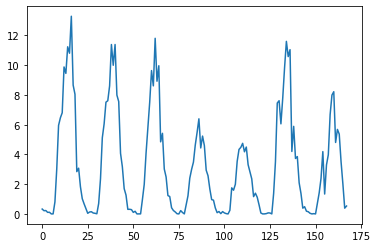

In [37]:
# Time mode
plt.plot(factors[0][:, 0])

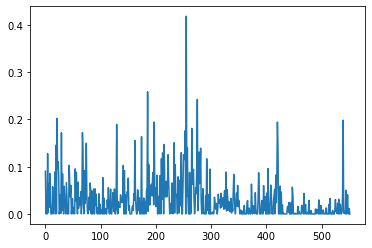

In [38]:
# Non-temporal mode (station)
plt.plot(factors[1][:, 4])

In [39]:
geo_component = pd.DataFrame(
    factors[1][:, 0],
    columns=['component'],
    index=multi_index.reset_index()[facets[0]].unique())

# geo_specific_data.join(df.set_index('startstationid'), how='outer')
geo_component

,component
72,5.388650e-02
79,4.544806e-02
82,1.632303e-02
83,1.256991e-02
116,3.883651e-02
...,...
3440,1.023480e-02
3443,6.829118e-02
3445,2.436931e-04
3447,5.955478e-03


In [40]:
lon_lat_keys = ['startstationlongitude', 'startstationlatitude']
geo_data = df.groupby('startstationid').mean()[lon_lat_keys]
lon_lat = geo_data.apply(my_transform, axis=1)
geo_data['trans_lon'], geo_data['trans_lat'] = zip(*lon_lat)
geo_data

,startstationlongitude,startstationlatitude,trans_lon,trans_lat
startstationid,,,,
72,-73.993929,40.767272,-8.236966e+06,4.978075e+06
79,-74.006667,40.719116,-8.238384e+06,4.970999e+06
82,-74.000165,40.711174,-8.237661e+06,4.969833e+06
83,-73.976323,40.683826,-8.235007e+06,4.965817e+06
116,-74.001497,40.741776,-8.237809e+06,4.974328e+06
...,...,...,...,...
3447,-73.956227,40.767034,-8.232770e+06,4.978040e+06
3450,-73.996924,40.751284,-8.237300e+06,4.975725e+06
3452,-73.948854,40.719156,-8.231949e+06,4.971005e+06


In [41]:
geo_component = geo_component.join(geo_data, how='left')

In [ ]:
sns.heatmap(data=geo_component, x='translon', y='trans')

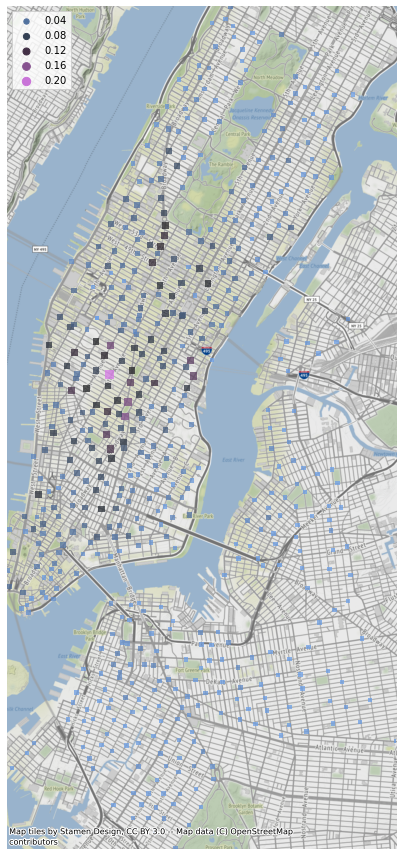

In [65]:
fig, ax = plt.subplots(figsize=(10, 12))

ax = sns.scatterplot(data=geo_component,
    x='trans_lon', y='trans_lat',
    marker='s',
    alpha=0.75,
    size='component',
    # palette='viridis',
    # palette=sns.color_palette("vlag", as_cmap=True),
    # palette=sns.color_palette("icefire", as_cmap=True),
    palette=sns.diverging_palette(250, 300, l=65, center="dark", as_cmap=True),
    edgecolor='none', hue='component')

ax.legend(fancybox=False)
ax.axis('off')
ax.margins(0)
cx.add_basemap(ax)
fig.tight_layout()
fig.savefig('sample-map.pdf', bbox_inches='tight', pad_inches=0)

In [178]:
def plot_age_component(factors, multi_index, mode, component_id=0, ax=None):

    # Non-temporal mode (user_age)
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    ages = multi_index.reset_index()[multi_index.index.names[mode-1]].unique()
    data = pd.DataFrame(factors[mode][:, component_id], index=ages)
    data.plot(ax=ax, legend=False)

    ax.set_xlabel("Age")
    ax.set_ylabel("Component strength")
    ax.set_title("User-age component")
    # ax.grid()

    return ax

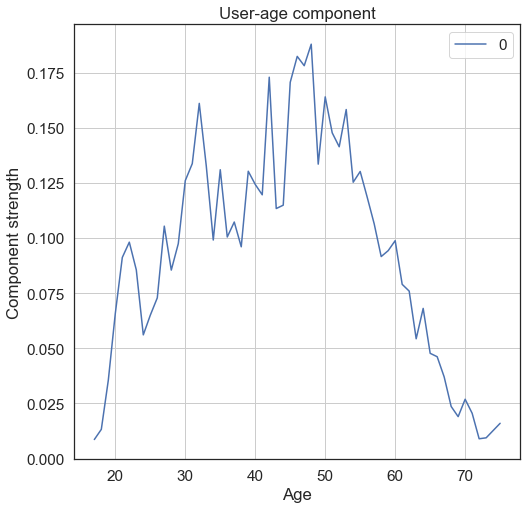

In [120]:
component_id = 0
# Non-temporal mode (user_age)
fig, ax = plt.subplots(figsize=(8, 8))

ages = multi_index.reset_index()[multi_index.index.names[1]].unique()
data = pd.DataFrame(factors[2][:, component_id], index=ages)
data.plot(ax=ax)

ax.set_xlabel("Age")
ax.set_ylabel("Component strength")
ax.set_title("User-age component")

ax.grid()


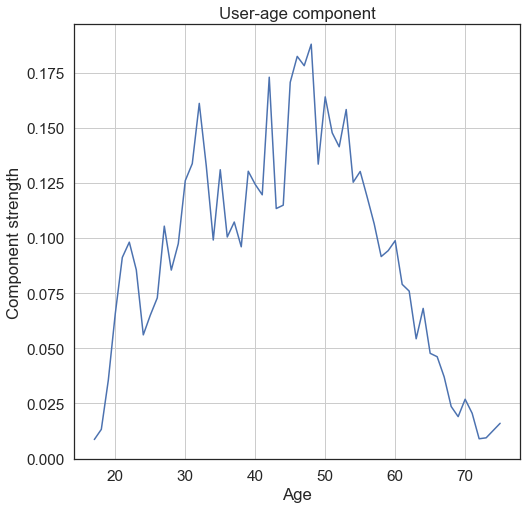

In [121]:
plot_age_component(factors, multi_index, mode=2)

## Plot sample

In [181]:
cid = 1
fig = plt.figure(figsize=(10, 9), constrained_layout=False)
spec = fig.add_gridspec(2, 2)
date_range = pd.date_range(end=d, periods=time_range, freq='H').strftime('%a %b %d')

ax0 = fig.add_subplot(spec[0, 0])
plot_time_component(factors, mode=0, component_id=cid, date_range=date_range, ax=ax0)
ax2 = fig.add_subplot(spec[1, 0])
plot_age_component(factors, multi_index, mode=2, component_id=cid, ax=ax2)
ax1 = fig.add_subplot(spec[:, 1])
plot_geo_component(factors, multi_index, mode=1, component_id=cid, ax=ax1)

fig.tight_layout()
fig.savefig('hoge.png')
plt.clf()
plt.close()

In [164]:
date_range = pd.date_range(end=d, periods=time_range, freq='H')
date_range.strftime('%a %b %d')

Index(['Wed Feb 01', 'Wed Feb 01', 'Wed Feb 01', 'Wed Feb 01', 'Wed Feb 01',
       'Wed Feb 01', 'Wed Feb 01', 'Wed Feb 01', 'Wed Feb 01', 'Wed Feb 01',
       ...
       'Tue Feb 07', 'Tue Feb 07', 'Tue Feb 07', 'Tue Feb 07', 'Tue Feb 07',
       'Tue Feb 07', 'Tue Feb 07', 'Tue Feb 07', 'Tue Feb 07', 'Tue Feb 07'],
      dtype='object', length=168)

In [184]:
for cid in tqdm.trange(rank):

    fig = plt.figure(figsize=(10, 9), constrained_layout=False)
    spec = fig.add_gridspec(2, 2)
    date_range = pd.date_range(end=d, periods=time_range, freq='H').strftime('%a %b %d')

    ax0 = fig.add_subplot(spec[0, 0])
    plot_time_component(factors, mode=0, component_id=cid, date_range=date_range, ax=ax0)
    ax2 = fig.add_subplot(spec[1, 0])
    plot_age_component(factors, multi_index, mode=2, component_id=cid, ax=ax2)
    ax1 = fig.add_subplot(spec[:, 1])
    plot_geo_component(factors, multi_index, mode=1, component_id=cid, ax=ax1)

    fig.tight_layout()
    fig.savefig(OUTDIR + f'time-geo-age-component{cid}.png')
    plt.clf()
    plt.close()

100%|██████████| 15/15 [02:21<00:00,  9.41s/it]


In [208]:
def plot_all_components(factors, multi_index, geo_data, end_date, time_range, wd=5, outfn=None):

    rank = factors[0].shape[1]
    fig = plt.figure(figsize=(rank*wd, 4*wd), constrained_layout=False)
    spec = fig.add_gridspec(4, rank)
    date_range = pd.date_range(end=end_date, periods=time_range, freq='H').strftime('%a %b %d')

    for cid in tqdm.trange(rank):

        ax0 = fig.add_subplot(spec[3, cid])
        plot_time_component(factors, mode=0, component_id=cid, date_range=date_range, ax=ax0)
        ax2 = fig.add_subplot(spec[2, cid])
        plot_age_component(factors, multi_index, mode=2, component_id=cid, ax=ax2)
        ax1 = fig.add_subplot(spec[:2, cid])
        plot_geo_component(factors, multi_index, mode=1, component_id=cid, geo_data=geo_data, ax=ax1)

        # break

    if outfn is not None:
        fig.tight_layout()
        fig.savefig(outfn, bbox_inches='tight')
        plt.clf()
        plt.close()

In [214]:
def sliding_window_decomposition(outdir, date='201701'):

    df = load_data(date=date)

    # Input information
    skip_mode = [False, False]
    facets = ['startstationid', 'user_age']
    multi_index, shape = define_non_temporal_modes(df, facets, skip_mode=skip_mode)

    # Geo information
    geo_mode = 1
    facet_name = multi_index.index.names[geo_mode-1]
    prefix = facet_name.rstrip('id')
    lon_lat_keys = [prefix + s for s in ['longitude', 'latitude']]
    geo_data = df.groupby(facet_name).mean()[lon_lat_keys]
    lon_lat = geo_data.apply(my_transform, axis=1)
    geo_data['trans_lon'], geo_data['trans_lat'] = zip(*lon_lat)

    # Decomposition setting
    rank = 15
    time_range = 168
    sub_tensor = np.zeros((time_range, *shape))

    for t, (d, g) in enumerate(df.set_index('starttime').groupby(pd.Grouper(freq='H'))):
        # t: time point
        # d: datetime information
        # g: trip data in an hour

        events = multi_index.join(g.groupby(facets).size().rename('data'), how='left')
        tensor = events.data.fillna(0.).values.reshape((-1, *shape))
        # print(tensor.shape)
        sub_tensor[t % time_range] = tensor

        if t % time_range == time_range - 1:
            print(d)
            # Perform tensnor decomposition
            weights, factors = non_negative_parafac(sub_tensor, rank)

            # Visualization
            outfn = outdir + f'{d.strftime("%Y-%m%d")}-time-geo-age-components.png'
            plot_all_components(factors, multi_index, geo_data, d, time_range, outfn=outfn)
            # break

In [223]:
outdir = '../out/sliding_window/time-geo-age/'
os.makedirs(outdir, exist_ok=True)

for date in pd.date_range(start='2017-01-01', end='2021-01-01', freq='M'):
    print(date.strftime('%Y%m'))
    sliding_window_decomposition(outdir, date.strftime('%Y%m'))

201701
Filtered out 8762 samples
2017-01-07 23:00:00


100%|██████████| 15/15 [00:17<00:00,  1.20s/it]


2017-01-14 23:00:00


100%|██████████| 15/15 [00:17<00:00,  1.18s/it]


2017-01-21 23:00:00


100%|██████████| 15/15 [00:17<00:00,  1.17s/it]


2017-01-28 23:00:00


100%|██████████| 15/15 [00:17<00:00,  1.18s/it]


201702
Filtered out 7999 samples
2017-02-07 23:00:00


100%|██████████| 15/15 [00:17<00:00,  1.17s/it]


2017-02-14 23:00:00


100%|██████████| 15/15 [00:17<00:00,  1.17s/it]


2017-02-21 23:00:00


100%|██████████| 15/15 [00:17<00:00,  1.17s/it]


2017-02-28 23:00:00


100%|██████████| 15/15 [00:17<00:00,  1.18s/it]


201703
Filtered out 7841 samples
2017-03-07 23:00:00


100%|██████████| 15/15 [00:18<00:00,  1.20s/it]


2017-03-14 23:00:00


100%|██████████| 15/15 [00:17<00:00,  1.19s/it]


2017-03-21 23:00:00


100%|██████████| 15/15 [00:17<00:00,  1.19s/it]


2017-03-28 23:00:00


100%|██████████| 15/15 [00:17<00:00,  1.19s/it]


201704
Filtered out 13751 samples
2017-04-07 23:00:00


100%|██████████| 15/15 [00:18<00:00,  1.20s/it]


2017-04-14 23:00:00


100%|██████████| 15/15 [00:17<00:00,  1.19s/it]


2017-04-21 23:00:00


100%|██████████| 15/15 [00:18<00:00,  1.22s/it]


2017-04-28 23:00:00


100%|██████████| 15/15 [00:17<00:00,  1.17s/it]


201705
Filtered out 16011 samples
2017-05-07 23:00:00


100%|██████████| 15/15 [00:17<00:00,  1.19s/it]


2017-05-14 23:00:00


100%|██████████| 15/15 [00:17<00:00,  1.19s/it]


2017-05-21 23:00:00


100%|██████████| 15/15 [00:17<00:00,  1.18s/it]


2017-05-28 23:00:00


100%|██████████| 15/15 [00:17<00:00,  1.17s/it]


201706
Filtered out 20818 samples
2017-06-07 23:00:00


100%|██████████| 15/15 [00:18<00:00,  1.22s/it]


2017-06-14 23:00:00


100%|██████████| 15/15 [00:18<00:00,  1.23s/it]


2017-06-21 23:00:00


100%|██████████| 15/15 [00:17<00:00,  1.20s/it]


2017-06-28 23:00:00


100%|██████████| 15/15 [00:17<00:00,  1.17s/it]


201707
Filtered out 24417 samples
2017-07-07 23:00:00


100%|██████████| 15/15 [00:17<00:00,  1.19s/it]


2017-07-14 23:00:00


100%|██████████| 15/15 [00:18<00:00,  1.23s/it]


2017-07-21 23:00:00


100%|██████████| 15/15 [00:18<00:00,  1.22s/it]


2017-07-28 23:00:00


100%|██████████| 15/15 [00:17<00:00,  1.18s/it]


201708
Filtered out 22984 samples
2017-08-07 23:00:00


100%|██████████| 15/15 [00:20<00:00,  1.36s/it]


2017-08-14 23:00:00


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


2017-08-21 23:00:00


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


2017-08-28 23:00:00


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


201709
Filtered out 9749 samples
2017-09-07 23:00:00


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


2017-09-14 23:00:00


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


2017-09-21 23:00:00


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


2017-09-28 23:00:00


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


201710
Filtered out 13033 samples
2017-10-07 23:00:00


100%|██████████| 15/15 [00:16<00:00,  1.11s/it]


2017-10-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


2017-10-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


2017-10-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


201711
Filtered out 11559 samples
2017-11-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


2017-11-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


2017-11-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


2017-11-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


201712
Filtered out 8309 samples
2017-12-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


2017-12-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


2017-12-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


2017-12-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


201801
Filtered out 6821 samples
2018-01-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


2018-01-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


2018-01-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


2018-01-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


201802
Filtered out 8507 samples
2018-02-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


2018-02-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


2018-02-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


2018-02-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


201803
Filtered out 9820 samples
2018-03-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


2018-03-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


2018-03-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


2018-03-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


201804
Filtered out 14826 samples
2018-04-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


2018-04-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


2018-04-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


2018-04-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


201805
Filtered out 21029 samples
2018-05-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


2018-05-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


2018-05-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


2018-05-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


201806
Filtered out 24079 samples
2018-06-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


2018-06-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


2018-06-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


2018-06-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


201807
Filtered out 25899 samples
2018-07-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


2018-07-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


2018-07-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


2018-07-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


201808
Filtered out 28745 samples
2018-08-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


2018-08-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


2018-08-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


2018-08-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


201809
Filtered out 29253 samples
2018-09-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


2018-09-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


2018-09-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


2018-09-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


201810
Filtered out 26592 samples
2018-10-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


2018-10-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


2018-10-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


2018-10-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


201811
Filtered out 16299 samples
2018-11-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


2018-11-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


2018-11-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


2018-11-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


201812
Filtered out 13518 samples
2018-12-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


2018-12-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


2018-12-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


2018-12-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


201901
Filtered out 11789 samples
2019-01-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


2019-01-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


2019-01-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


2019-01-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


201902
Filtered out 11798 samples
2019-02-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


2019-02-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


2019-02-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


2019-02-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


201903
Filtered out 18928 samples
2019-03-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


2019-03-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


2019-03-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


2019-03-28 23:00:00


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


201904
Filtered out 21724 samples
2019-04-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


2019-04-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


2019-04-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


2019-04-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


201905
Filtered out 25127 samples
2019-05-07 23:00:00


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


2019-05-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


2019-05-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


2019-05-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


201906
Filtered out 32458 samples
2019-06-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


2019-06-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


2019-06-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


2019-06-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


201907
Filtered out 35424 samples
2019-07-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


2019-07-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


2019-07-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


2019-07-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


201908
Filtered out 36960 samples
2019-08-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


2019-08-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


2019-08-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


2019-08-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


201909
Filtered out 31920 samples
2019-09-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


2019-09-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


2019-09-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


2019-09-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


201910
Filtered out 18773 samples
2019-10-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


2019-10-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


2019-10-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


2019-10-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


201911
Filtered out 11282 samples
2019-11-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


2019-11-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


2019-11-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


2019-11-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


201912
Filtered out 8136 samples
2019-12-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


2019-12-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


2019-12-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


2019-12-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


202001
Filtered out 10062 samples
2020-01-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


2020-01-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


2020-01-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


2020-01-28 23:00:00


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


202002
Filtered out 9611 samples
2020-02-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


2020-02-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


2020-02-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


2020-02-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


202003
Filtered out 12079 samples
2020-03-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


2020-03-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


2020-03-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


2020-03-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


202004
Filtered out 11306 samples
2020-04-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


2020-04-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


2020-04-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


2020-04-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


202005
Filtered out 20472 samples
2020-05-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


2020-05-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


2020-05-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


2020-05-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


202006
Filtered out 23789 samples
2020-06-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


2020-06-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


2020-06-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


2020-06-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


202007
Filtered out 23150 samples
2020-07-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


2020-07-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


2020-07-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


2020-07-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


202008
Filtered out 24610 samples
2020-08-07 23:00:00


100%|██████████| 15/15 [00:16<00:00,  1.09s/it]


2020-08-14 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


2020-08-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


2020-08-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


202009
Filtered out 22363 samples
2020-09-07 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


2020-09-14 23:00:00


100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


2020-09-21 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


2020-09-28 23:00:00


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


202010
Filtered out 19125 samples
2020-10-07 23:00:00


100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


2020-10-14 23:00:00


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


2020-10-21 23:00:00


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


2020-10-28 23:00:00


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


202011
Filtered out 16818 samples
2020-11-07 23:00:00


100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


2020-11-14 23:00:00


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


2020-11-21 23:00:00


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


2020-11-28 23:00:00


100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


202012
Filtered out 9632 samples
2020-12-07 23:00:00


100%|██████████| 15/15 [00:15<00:00,  1.02s/it]


2020-12-14 23:00:00


100%|██████████| 15/15 [00:16<00:00,  1.10s/it]


2020-12-21 23:00:00


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


2020-12-28 23:00:00


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]
